# Integrators Comparison

Here I will compare several integrators to analyse difference in their accuracy, energy and momenta preservation.


In [18]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [19]:
I = np.diag([0, 1, 1, 1])
q_0 = [1, 0, 0, 0]
w_0 = [0, 0, 0]

In [20]:
t0 = 0
tf = 3
steps = 200
u = np.array([0, 0, 0, 0])
Kt = 0.1
Km = 0.1

In [21]:
q0 = sp.Matrix(sp.symbols("q_00, q_01, q_02, q_03"))
q1 = sp.Matrix(sp.symbols("q_10, q_11, q_12, q_13"))
momentum0 = sp.Matrix(sp.symbols("p_0, p_1, p_2, p_3"))
dt = sp.Symbol("dt")
lambda0 = sp.Symbol("lambda_0")

In [22]:
# Skew symmetric quaternion matrix
def Lq(q1):
    L = sp.Matrix(
        [
            [q1[0], -q1[1], -q1[2], -q1[3]],
            [q1[1], q1[0], -q1[3], q1[2]],
            [q1[2], q1[3], q1[0], -q1[1]],
            [q1[3], -q1[2], q1[1], q1[0]],
        ]
    )

    return L


# Quaternion conjugate
def qconj(q):
    return sp.Matrix([q[0], -q[1], -q[2], -q[3]])


# Angular velocity expressed in quaternions
def w(q, dq):
    return 2 * Lq(qconj(q)) @ dq

In [23]:
# Kinetic energy of the system expressed in quaternions
def kinetic_energy(q, dq):
    return 0.5 * w(q, dq).T @ I @ w(q, dq)


def momentum(q, dq):
    return kinetic_energy(q, dq)[0].diff(dq)

In [24]:
# The first (and only one) constraint
def phi0(q):
    return 1 / 2 * (q[0] ** 2 + q[1] ** 2 + q[2] ** 2 + q[3] ** 2 - 1)

In [25]:
tau = sp.Matrix([0, 0, 0, 100])

# Incorporating forces

Tried two approaches

1. Add generalized force to residual, just like West
2. Add generalzied force @ variation to the action functional

The first one yields constant acceleration and I am not sure why. The second one works just fine. Probably I need more time for mathematical formulations. Also variation is time derivative in my case...


In [26]:
# Discrete lagrangian of the system
def discrete_L(q0, q1, dt):
    ke = kinetic_energy((q0 + q1) / 2, (q1 - q0) / dt)[0]
    dq = (q1 + q0) / 2
    forces = ((Lq(q0) @ tau).T @ dq)[0]

    return (forces + ke) * dt

In [27]:
momentum_residual = (
    momentum0
    + sp.Matrix([discrete_L(q0, q1, dt)]).jacobian(q0).T
    + phi0(q0).diff(q0) * lambda0
)
momentum_next = sp.Matrix([discrete_L(q0, q1, dt)]).jacobian(q1).T

In [28]:
dq = sp.Matrix(sp.symbols("dq_0, dq_1, dq_2, dq_3"))

num = dict(
    momentum_residual=sp.lambdify((q0, q1, momentum0, dt, lambda0), momentum_residual),
    momentum_next=sp.lambdify((q0, q1, dt), momentum_next),
    phi0=sp.lambdify(q0, phi0(q0)),
    kinetic_energy=sp.lambdify((q0, dq), kinetic_energy(q0, dq)),
    momentum=sp.lambdify((q0, dq), momentum(q0, dq)),
)

# TODO

Discuss indexes of $\lambda$.

Note:

- I think it should be $\lambda_k^0, \lambda_k^1$, i.e. k-th lambda for two variables, rather than $\lambda_0, \lambda_1$ which confuses a lot
- Moreover, we need it nowhere except the calculation itself afaik


Constrained DELM should like the following:

$$ \begin{equation} \begin{array}{c} \begin{cases} p_k + D_1L_d(q_k, q_{k+1}) + \frac{\partial \phi}{\partial q_k}^T(q_{k})\lambda_{k}^0 = 0\ \phi(q_{k+1}) = 0 \end{cases}\ p_{k+1} = D_2L_d(q_k, q_{k+1}) \end{array} \end{equation} $$

# The algorithm:

1. Express $q_{k+1}$ and $\lambda_{k}$ through the system
2. Find the next momentum with the formula
3. Repeat

# Initialization

- Initial position is given: $[1, 0, 0, 0]$
- Initial velocity is given: $[6, 0.1, 0.1]$
- Inertia parameters are given: $[0.1, 0.2, 0.4]$ (Ix, Iy, Iz respectively)
- Initial momentum should be calculated as follows:

Knowing initial state we can easilly derive momentum from the kinetic energy $$ p = M\dot{q} = \frac{\partial H}{\partial \dot{q}} = \frac{\partial K}{\partial \dot{q}} $$


In [29]:
def vi_solution(q0, w0, tspan, N=1000):
    dt = (tspan[1] - tspan[0]) / N

    state = dict(
        qs=np.zeros((N, 4)),
        ps=np.zeros((N, 4)),
        ke=np.zeros(N),
        phi0=np.zeros(N),
    )

    state["qs"][0] = q0
    dq0 = 1 / 2 * Lq(q0) @ np.array([0, *w0])
    state["ps"][0] = num["momentum"](q0, dq0).flatten()

    def system_for_q(q, q0, p0, dt):
        residual = num["momentum_residual"](q0, q[:4], p0, dt, q[4])
        residual = np.array(residual.T.flatten())

        return np.array([*residual, num["phi0"](*q[:4])])

    def next_momentum(q0, q1, dt):
        return num["momentum_next"](q0, q1, dt).T.flatten()

    for i in range(1, N):
        prev_q = state["qs"][i - 1]
        prev_p = state["ps"][i - 1]
        state["qs"][i] = fsolve(system_for_q, [*prev_q, 0], args=(prev_q, prev_p, dt))[
            :4
        ]
        state["ps"][i] = next_momentum(prev_q, state["qs"][i], dt)
        state["ke"][i] = num["kinetic_energy"](
            state["qs"][i], (state["qs"][i] - prev_q) / dt
        )
        state["phi0"][i] = num["phi0"](*state["qs"][i]) - 1

    state["ke"][0] = state["ke"][1]
    state["phi0"][0] = state["phi0"][1]
    return state

In [30]:
res_vi = vi_solution(q_0, w_0, (t0, tf), N=steps)

/tmp/ipykernel_21250/1355386277.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state["ke"][i] = num["kinetic_energy"](


In [31]:
print(res_vi["qs"][1])

[ 9.99996045e-01  4.62221362e-35  9.24442708e-35 -2.81250000e-03]


In [32]:
import numpy as np


def quaternion_to_rotation_matrix(q):
    q = np.array(q)
    q /= np.linalg.norm(q)
    w, x, y, z = q

    rotation_matrix = np.array(
        [
            [1 - 2 * y**2 - 2 * z**2, 2 * x * y - 2 * w * z, 2 * x * z + 2 * w * y],
            [2 * x * y + 2 * w * z, 1 - 2 * x**2 - 2 * z**2, 2 * y * z - 2 * w * x],
            [2 * x * z - 2 * w * y, 2 * y * z + 2 * w * x, 1 - 2 * x**2 - 2 * y**2],
        ]
    )

    return rotation_matrix

In [33]:
qs = res_vi["qs"]
basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rms = np.array([quaternion_to_rotation_matrix(q) for q in qs])

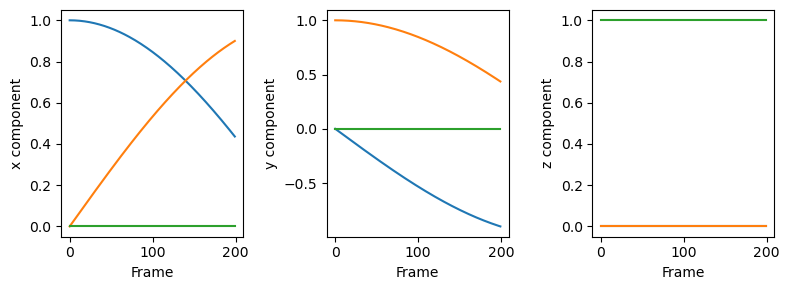

In [34]:
import matplotlib.pyplot as plt

# Extract the x, y, z components of the basis vectors
x = rms[:, 0]
y = rms[:, 1]
z = rms[:, 2]

# Create three separate plots for x, y, z components
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

# Plot x component
ax1.plot(x)
ax1.set_xlabel("Frame")
ax1.set_ylabel("x component")

# Plot y component
ax2.plot(y)
ax2.set_xlabel("Frame")
ax2.set_ylabel("y component")

# Plot z component
ax3.plot(z)
ax3.set_xlabel("Frame")
ax3.set_ylabel("z component")

# Display the plots
plt.tight_layout()
plt.show()

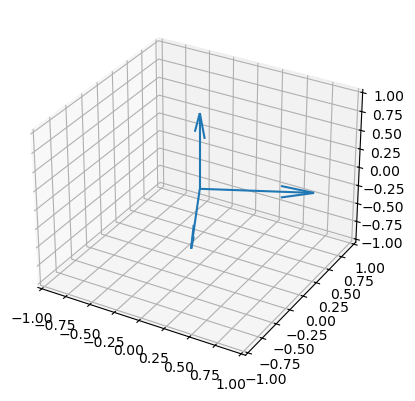

In [35]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

basis = ax.quiver(0, 0, 0, basis_vectors[0], basis_vectors[1], basis_vectors[2])


def update(frame):
    # Rotate the basis vectors
    rotated_vectors = rms[frame] @ basis_vectors.T

    global basis
    basis.remove()
    basis = ax.quiver(
        0, 0, 0, rotated_vectors[0], rotated_vectors[1], rotated_vectors[2]
    )


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs), interval=tf * 1000 / steps)

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history.gif")

# Display the animation
plt.show()